In [52]:
import pandas as pd
import os
from praatio import textgrid
import matplotlib.pyplot as plt
import parselmouth as pm

In [79]:
data_folder = "../output/vowel_length_Amplitude_smooth10_threshold0.08_min0/"
behavioral_data = "../input/behavioral/data_exp_227135-v7_task-zhmn.csv"



participant_id_col = 'Participant Private ID'
response_identifier_col = 'Tag'
response_identifier_value = 'response'
response_col = 'Response'
condition_col = 'Spreadsheet: condition'

test_stim_col = 'Spreadsheet: TestName'
block_col = "Spreadsheet: randomise_trials"

reaction_time_col = 'Reaction Time'

experiment_id_col = 'Experiment ID'
experiment_version_col = 'Experiment Version'
tree_node_key_col = 'Tree Node Key'
schedule_id_col = 'Schedule ID'
record_name_col = 'Spreadsheet: RecordName'

response1 = 'set'
response0 = 'sat'
practice_trials_name = 'Practice'

task_builder = 2

In [54]:
behavior_data = pd.read_csv(behavioral_data)
perceptual_data = behavior_data.loc[behavior_data[response_identifier_col] == response_identifier_value]
len(perceptual_data)

655

In [55]:
perceptual_data.loc[perceptual_data[response_col] == response0,'response_num'] =0
perceptual_data.loc[perceptual_data[response_col] == response1,'response_num'] =1

perceptual_data_critical = perceptual_data.loc[perceptual_data[condition_col] != practice_trials_name,:]

/tmp/ipykernel_1125/3656716612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perceptual_data.loc[perceptual_data[response_col] == response0,'response_num'] =0


In [56]:

if task_builder ==1:
    perceptual_data_critical['recording_main_name'] =  perceptual_data_critical[experiment_id_col].astype(int).astype(str) + '-'  + perceptual_data_critical[experiment_version_col].astype(int).astype(str)  + '-'  +  \
                                                       perceptual_data_critical[participant_id_col].astype(int).astype(str)    + '-'  +    perceptual_data_critical[tree_node_key_col] + '-'  +  \
                                                       perceptual_data_critical[schedule_id_col].astype(int).astype(str)   + '-'  +  perceptual_data_critical[record_name_col].map(lambda x: x.replace('_',''))   
    
elif task_builder == 2:
    perceptual_data_critical['recording_main_name'] =  perceptual_data_critical[experiment_id_col].astype(int).astype(str) + '-'  + perceptual_data_critical[experiment_version_col].astype(int).astype(str)  + '-'  +  \
                                                       perceptual_data_critical[participant_id_col].astype(int).astype(str)    + '-'  +    perceptual_data_critical[tree_node_key_col] + '-'  +  \
                                                       perceptual_data_critical[schedule_id_col].astype(int).astype(str)   + '-'  +  perceptual_data_critical[record_name_col]
else:
    print('task builder version not found')
        


/tmp/ipykernel_1125/991376533.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perceptual_data_critical['recording_main_name'] =  perceptual_data_critical[experiment_id_col].astype(int).astype(str) + '-'  + perceptual_data_critical[experiment_version_col].astype(int).astype(str)  + '-'  +  \


In [57]:
file_dict = {}

p_folders = os.listdir(data_folder)
for p in p_folders:
    file_dict.update({'-'.join(fi.split('-')[0:7]) : f"{p}/{fi}" for fi in os.listdir(f'{data_folder}/{p}') if fi[-9:] == '.TextGrid'})


In [58]:
class VowelLength:
    
    def __init__(self, filename):

        tg = pm.TextGrid.read(filename)


        
        self.tg = tg
        self.num_intervals = pm.praat.call(tg, "Get number of intervals", 1)
        self.filename = filename


        self.intervals = []
        for x in range(self.num_intervals):
            self.intervals.append( (pm.praat.call(tg, "Get start time of interval", 1, x+1), pm.praat.call(tg, "Get end time of interval", 1, x+1)))

        self.interval_lengths = [ i[1] - i[0] for i in self.intervals]

        

In [59]:
creation_error = []
file_error = []
interval_error = []
print(f'total files: {len(perceptual_data_critical["recording_main_name"])}')
loading_counter = 0
for record_name in perceptual_data_critical['recording_main_name']:
    # print(f'loading {record_name}')
    loading_counter+=1
    if loading_counter%100 == 0:
        print(f'files_loaded: {loading_counter}')
    try:
        vl = VowelLength(f'{data_folder}/{file_dict[ record_name ]}')
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'vowel_length'] = vl
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'num_intervals'] = vl.num_intervals
    
    
    except KeyError:
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'vowel_length'] = None
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'num_intervals'] = None
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'vowel_interval2_length'] = None
        file_error.append(record_name)
        continue
        
    except ValueError:
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'vowel_length'] = None
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'num_intervals'] = None
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'vowel_interval2_length'] = None
        creation_error.append(record_name)
        continue
        
        


    try:
        vowel_interval2_length = vl.interval_lengths[1]
        if vl.num_intervals >3:
            interval_error.append(record_name)
            vl.num_intervals = None
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'vowel_interval2_length'] = vl.interval_lengths[1]
    except IndexError:
        perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'vowel_interval2_length'] = None
        interval_error.append(record_name)
        
        
print(f'file error: {len(file_error)}, creation error: {len(creation_error)}, interval error: {len(interval_error)}')

total files: 640


/tmp/ipykernel_1125/1596038347.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'vowel_length'] = vl
/tmp/ipykernel_1125/1596038347.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perceptual_data_critical.loc[perceptual_data_critical['recording_main_name']==record_name, 'num_intervals'] = vl.num_intervals
/tmp/ipykernel_1125/1596038347.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

files_loaded: 100
files_loaded: 200
files_loaded: 300
files_loaded: 400
files_loaded: 500
files_loaded: 600
file error: 0, creation error: 0, interval error: 60


(array([ 1.,  0.,  0.,  0., 40., 69., 38., 26., 27.,  3.,  1.,  0.,  2.,
         1.,  4.,  9.,  5.,  2.,  1.,  1.]),
 array([0.0489703 , 0.08029381, 0.11161732, 0.14294084, 0.17426435,
        0.20558787, 0.23691138, 0.2682349 , 0.29955841, 0.33088193,
        0.36220544, 0.39352896, 0.42485247, 0.45617599, 0.4874995 ,
        0.51882302, 0.55014653, 0.58147005, 0.61279356, 0.64411707,
        0.67544059]),
 <BarContainer object of 20 artists>)

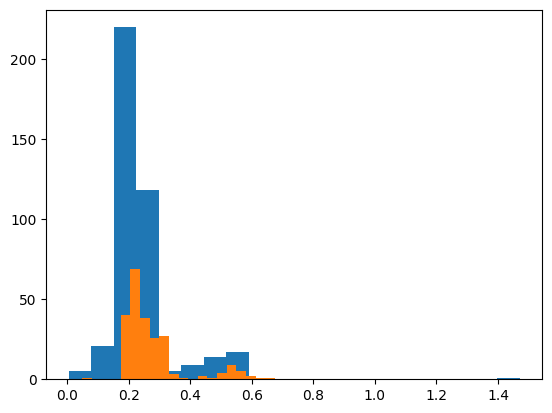

In [64]:
fig, ax = plt.subplots(1,1)

ax.hist(perceptual_data_critical.loc[perceptual_data_critical[response_col]=='set', 'vowel_interval2_length'], bins = 20)
ax.hist(perceptual_data_critical.loc[perceptual_data_critical[response_col]=='sat', 'vowel_interval2_length'], bins = 20)

In [61]:
for p in set(perceptual_data_critical[participant_id_col]):
    p_avg = perceptual_data_critical.loc[perceptual_data_critical[participant_id_col] == p, "vowel_interval2_length"].mean()
    p_std = perceptual_data_critical.loc[perceptual_data_critical[participant_id_col] == p, "vowel_interval2_length"].std()
    # print(p_avg, p_std)
    perceptual_data_critical.loc[perceptual_data_critical[participant_id_col] == p, "z_length"] = p_std = (
    perceptual_data_critical.loc[perceptual_data_critical[participant_id_col] == p, "vowel_interval2_length"] - p_avg)/p_std
    

/tmp/ipykernel_1125/1490229534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perceptual_data_critical.loc[perceptual_data_critical[participant_id_col] == p, "z_length"] = p_std = (


In [62]:
sum(perceptual_data_critical['num_intervals'] != 3.0)

63

## Exclusions

In [63]:
pre_length = len(perceptual_data_critical)
filtered_perceptual_data_critical = perceptual_data_critical.loc[perceptual_data_critical['num_intervals'] == 3.0]
post_length = len(filtered_perceptual_data_critical)
print(f'removed due to no length value: {pre_length -post_length}') 

pre_length = len(filtered_perceptual_data_critical)
filtered_perceptual_data_critical = filtered_perceptual_data_critical.loc[perceptual_data_critical['z_length'] <= 3]
post_length = len(filtered_perceptual_data_critical)
print(f'removed due to z score above 3 sd: {pre_length -post_length}') 


pre_length = len(filtered_perceptual_data_critical)
filtered_perceptual_data_critical = filtered_perceptual_data_critical.loc[perceptual_data_critical['z_length'] >= -3]
post_length = len(filtered_perceptual_data_critical)
print(f'removed due to z score below 3 sd: {pre_length -post_length}') 

pre_length = len(filtered_perceptual_data_critical)
filtered_perceptual_data_critical = filtered_perceptual_data_critical.loc[perceptual_data_critical[reaction_time_col] >= 3]
post_length = len(filtered_perceptual_data_critical)
print(f'removed due to rt above 3: {pre_length -post_length}') 

pre_length = len(filtered_perceptual_data_critical)
filtered_perceptual_data_critical = filtered_perceptual_data_critical.loc[perceptual_data_critical[ "vowel_interval2_length"] <= 1]
post_length = len(filtered_perceptual_data_critical)
print(f'removed due to vowel length above 1 second: {pre_length -post_length}') 

pre_length = len(filtered_perceptual_data_critical)
filtered_perceptual_data_critical = filtered_perceptual_data_critical.loc[perceptual_data_critical[ "vowel_interval2_length"] >= 0.05]
post_length = len(filtered_perceptual_data_critical)
print(f'removed due to vowel length below 50 ms: {pre_length -post_length}') 

removed due to no length value: 63
removed due to z score above 3 sd: 1
removed due to z score below 3 sd: 0
removed due to rt above 3: 0
removed due to vowel length above 1 second: 0
removed due to vowel length below 50 ms: 0


In [120]:
sum_stats_response_wide_byp_sat

Participant Private ID,13465624,13465820,13465869,13467090,13468326
Spreadsheet: condition,,,,,
Canonical,0.232428,0.309608,0.487442,0.226513,0.211920
Reverse,0.225432,0.295159,0.575428,0.242574,0.203901


# Raw Values

## Production By Pecept

In [119]:
sum_stats_response = perceptual_data_critical[[condition_col, response_col, "vowel_interval2_length"]].groupby([condition_col, response_col]).mean()
sum_stats_response = sum_stats_response.reset_index()
sum_stats_response_wide = sum_stats_response.pivot(index = condition_col, columns = response_col, values = "vowel_interval2_length")

perceptual_data_critical_set = perceptual_data_critical.loc[perceptual_data_critical[response_col]=='set']
perceptual_data_critical_sat = perceptual_data_critical.loc[perceptual_data_critical[response_col]=='sat']

sum_stats_response_byp_set = perceptual_data_critical_set[[condition_col, participant_id_col, "vowel_interval2_length"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_response_byp_set = sum_stats_response_byp_set.reset_index()
sum_stats_response_wide_byp_set = sum_stats_response_byp_set.pivot(index = condition_col, columns = participant_id_col, values = "vowel_interval2_length")

sum_stats_response_byp_sat = perceptual_data_critical_sat[[condition_col, participant_id_col, "vowel_interval2_length"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_response_byp_sat = sum_stats_response_byp_sat.reset_index()
sum_stats_response_wide_byp_sat = sum_stats_response_byp_sat.pivot(index = condition_col, columns = participant_id_col, values = "vowel_interval2_length")

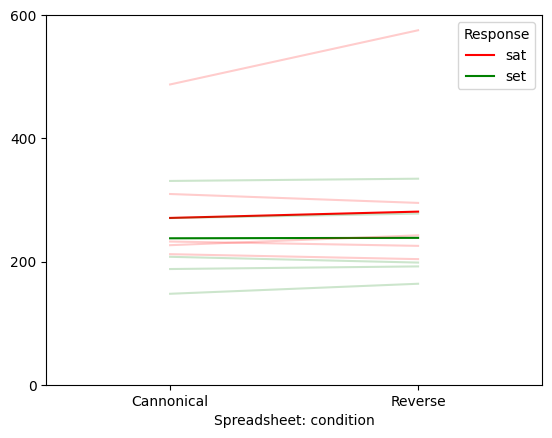

In [71]:
fig, ax = plt.subplots(1,1)
sum_stats_response_wide.plot.line(ax = ax, color = ['red', 'green'])
ax.set_ylim(0,0.6)
ax.set_xticks([0,1],['Cannonical', 'Reverse'])
ax.set_xlim([-0.5, 1.5])
ax.set_yticks([0,0.2,0.4,0.6,], [0,200,400,600,])

for p in sum_stats_response_wide_byp_sat.columns:
    ax.plot(sum_stats_response_wide_byp_sat[[p]], color = 'red', alpha = 0.2)
    ax.plot(sum_stats_response_wide_byp_set[[p]], color = 'green', alpha = 0.2)
    

In [80]:
sum_stats_response = perceptual_data_critical[[block_col, response_col, "vowel_interval2_length"]].groupby([block_col, response_col]).mean()
sum_stats_response = sum_stats_response.reset_index()
sum_stats_response_wide = sum_stats_response.pivot(index = block_col, columns = response_col, values = "vowel_interval2_length")

perceptual_data_critical_set = perceptual_data_critical.loc[perceptual_data_critical[response_col]=='set']
perceptual_data_critical_sat = perceptual_data_critical.loc[perceptual_data_critical[response_col]=='sat']

sum_stats_response_byp_set = perceptual_data_critical_set[[block_col, participant_id_col, "vowel_interval2_length"]].groupby([block_col, participant_id_col]).mean()
sum_stats_response_byp_set = sum_stats_response_byp_set.reset_index()
sum_stats_response_wide_byp_set = sum_stats_response_byp_set.pivot(index = block_col, columns = participant_id_col, values = "vowel_interval2_length")

sum_stats_response_byp_sat = perceptual_data_critical_sat[[block_col, participant_id_col, "vowel_interval2_length"]].groupby([block_col, participant_id_col]).mean()
sum_stats_response_byp_sat = sum_stats_response_byp_sat.reset_index()
sum_stats_response_wide_byp_sat = sum_stats_response_byp_sat.pivot(index = block_col, columns = participant_id_col, values = "vowel_interval2_length")

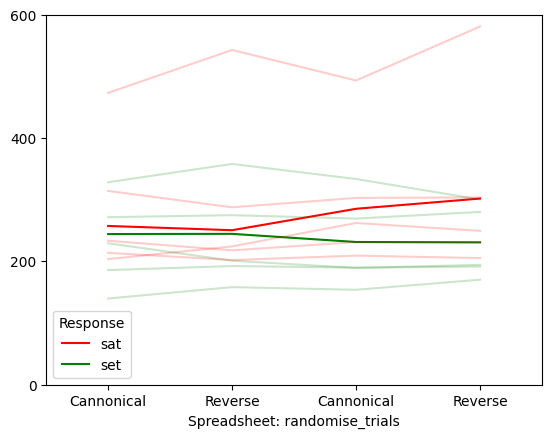

In [84]:
fig, ax = plt.subplots(1,1)
sum_stats_response_wide.plot.line(ax = ax, color = ['red', 'green'])
ax.set_ylim(0,0.6)
ax.set_xticks([1,2, 3, 4],['Cannonical', 'Reverse', 'Cannonical', 'Reverse'])
ax.set_xlim([0.5, 4.5])
ax.set_yticks([0,0.2,0.4,0.6,], [0,200,400,600,])

for p in sum_stats_response_wide_byp_sat.columns:
    ax.plot(sum_stats_response_wide_byp_sat[[p]], color = 'red', alpha = 0.2)
    ax.plot(sum_stats_response_wide_byp_set[[p]], color = 'green', alpha = 0.2)
    

## Production By Test Stimulus

In [121]:
sum_stats_stim = perceptual_data_critical[[condition_col, test_stim_col, "vowel_interval2_length"]].groupby([condition_col, test_stim_col]).mean()
sum_stats_stim = sum_stats_stim.reset_index()
sum_stats_stim_wide = sum_stats_stim.pivot(index = condition_col, columns = test_stim_col, values = "vowel_interval2_length")


perceptual_data_critical_dur2 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur2']
perceptual_data_critical_dur6 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur6']

sum_stats_stim_byp_dur2 = perceptual_data_critical_dur2[[condition_col, participant_id_col, "vowel_interval2_length"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_stim_byp_dur2 = sum_stats_stim_byp_dur2.reset_index()
sum_stats_stim_wide_byp_dur2 = sum_stats_stim_byp_dur2.pivot(index = condition_col, columns = participant_id_col, values = "vowel_interval2_length")

sum_stats_stim_byp_dur6 = perceptual_data_critical_dur6[[condition_col, participant_id_col, "vowel_interval2_length"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_stim_byp_dur6 = sum_stats_stim_byp_dur6.reset_index()
sum_stats_stim_wide_byp_dur6 = sum_stats_stim_byp_dur6.pivot(index = condition_col, columns = participant_id_col, values = "vowel_interval2_length")

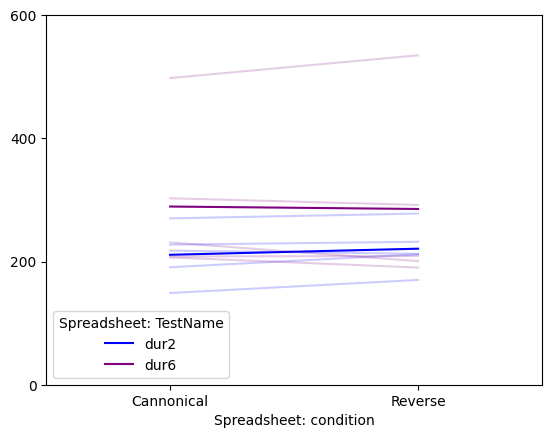

In [122]:
fig, ax = plt.subplots(1,1)
sum_stats_stim_wide.plot.line(ax = ax, color = ["blue","purple"])
ax.set_ylim(0,0.6)
ax.set_xticks([0,1],['Cannonical', 'Reverse'])
ax.set_xlim([-0.5, 1.5])
ax.set_yticks([0,0.2,0.4,0.6,], [0,200,400,600,])

for p in sum_stats_stim_wide_byp_dur2.columns:
    ax.plot(sum_stats_stim_wide_byp_dur2[[p]], color = 'blue', alpha = 0.2)
    ax.plot(sum_stats_stim_wide_byp_dur6[[p]], color = 'purple', alpha = 0.2)
    

In [123]:
sum_stats_stim = perceptual_data_critical[[block_col, test_stim_col, "vowel_interval2_length"]].groupby([block_col, test_stim_col]).mean()
sum_stats_stim = sum_stats_stim.reset_index()
sum_stats_stim_wide = sum_stats_stim.pivot(index = block_col, columns = test_stim_col, values = "vowel_interval2_length")


perceptual_data_critical_dur2 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur2']
perceptual_data_critical_dur6 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur6']

sum_stats_stim_byp_dur2 = perceptual_data_critical_dur2[[block_col, participant_id_col, "vowel_interval2_length"]].groupby([block_col, participant_id_col]).mean()
sum_stats_stim_byp_dur2 = sum_stats_stim_byp_dur2.reset_index()
sum_stats_stim_wide_byp_dur2 = sum_stats_stim_byp_dur2.pivot(index = block_col, columns = participant_id_col, values = "vowel_interval2_length")

sum_stats_stim_byp_dur6 = perceptual_data_critical_dur6[[block_col, participant_id_col, "vowel_interval2_length"]].groupby([block_col, participant_id_col]).mean()
sum_stats_stim_byp_dur6 = sum_stats_stim_byp_dur6.reset_index()
sum_stats_stim_wide_byp_dur6 = sum_stats_stim_byp_dur6.pivot(index = block_col, columns = participant_id_col, values = "vowel_interval2_length")

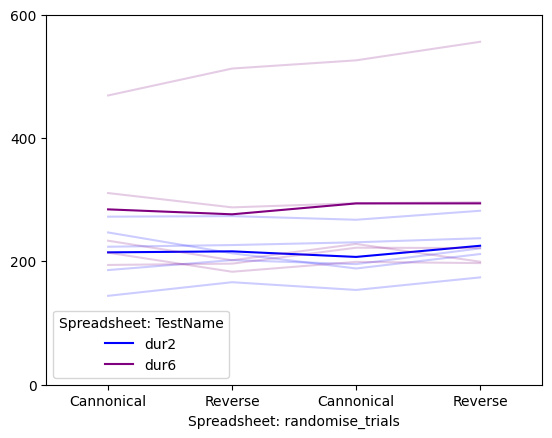

In [125]:
fig, ax = plt.subplots(1,1)
sum_stats_stim_wide.plot.line(ax = ax, color = ["blue","purple"])
ax.set_ylim(0,0.6)
ax.set_xticks([1,2, 3, 4],['Cannonical', 'Reverse', 'Cannonical', 'Reverse'])
ax.set_xlim([0.5, 4.5])
ax.set_yticks([0,0.2,0.4,0.6,], [0,200,400,600,])

for p in sum_stats_response_wide_byp_sat.columns:
    ax.plot(sum_stats_stim_wide_byp_dur2[[p]], color = 'blue', alpha = 0.2)
    ax.plot(sum_stats_stim_wide_byp_dur6[[p]], color = 'purple', alpha = 0.2)
    

## Perceptual Results

In [26]:
sum_stats_percept = perceptual_data_critical[[condition_col, test_stim_col, "response_num"]].groupby([condition_col, test_stim_col]).mean()
sum_stats_percept = sum_stats_percept.reset_index()
sum_stats_percept_wide = sum_stats_percept.pivot(index = condition_col, columns = test_stim_col, values = "response_num")


perceptual_data_critical_dur2 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur2']
perceptual_data_critical_dur6 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur6']

sum_stats_percept_byp_dur2 = perceptual_data_critical_dur2[[condition_col, participant_id_col, "response_num"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_percept_byp_dur2 = sum_stats_percept_byp_dur2.reset_index()
sum_stats_percept_wide_byp_dur2 = sum_stats_percept_byp_dur2.pivot(index = condition_col, columns = participant_id_col, values = "response_num")

sum_stats_percept_byp_dur6 = perceptual_data_critical_dur6[[condition_col, participant_id_col, "response_num"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_percept_byp_dur6 = sum_stats_percept_byp_dur6.reset_index()
sum_stats_percept_wide_byp_dur6 = sum_stats_percept_byp_dur6.pivot(index = condition_col, columns = participant_id_col, values = "response_num")

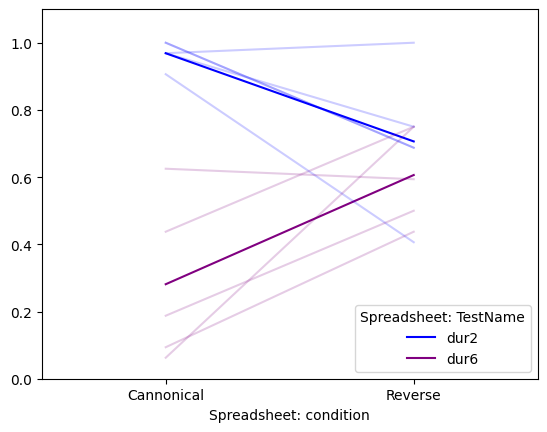

In [35]:
fig, ax = plt.subplots(1,1)
sum_stats_percept_wide.plot.line(ax = ax, color = ["blue","purple"])
ax.set_ylim(0,1.1)
ax.set_xticks([0,1],['Cannonical', 'Reverse'])
ax.set_xlim([-0.5, 1.5])

for p in sum_stats_stim_wide_byp_dur2.columns:
    ax.plot(sum_stats_percept_wide_byp_dur2[[p]], color = 'blue', alpha = 0.2)
    ax.plot(sum_stats_percept_wide_byp_dur6[[p]], color = 'purple', alpha = 0.2)

In [96]:
sum_stats_percept = perceptual_data_critical[[block_col, test_stim_col, "response_num"]].groupby([block_col, test_stim_col]).mean()
sum_stats_percept = sum_stats_percept.reset_index()
sum_stats_percept_wide = sum_stats_percept.pivot(index = block_col, columns = test_stim_col, values = "response_num")


perceptual_data_critical_dur2 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur2']
perceptual_data_critical_dur6 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur6']

sum_stats_percept_byp_dur2 = perceptual_data_critical_dur2[[block_col, participant_id_col, "response_num"]].groupby([block_col, participant_id_col]).mean()
sum_stats_percept_byp_dur2 = sum_stats_percept_byp_dur2.reset_index()
sum_stats_percept_wide_byp_dur2 = sum_stats_percept_byp_dur2.pivot(index = block_col, columns = participant_id_col, values = "response_num")

sum_stats_percept_byp_dur6 = perceptual_data_critical_dur6[[block_col, participant_id_col, "response_num"]].groupby([block_col, participant_id_col]).mean()
sum_stats_percept_byp_dur6 = sum_stats_percept_byp_dur6.reset_index()
sum_stats_percept_wide_byp_dur6 = sum_stats_percept_byp_dur6.pivot(index = block_col, columns = participant_id_col, values = "response_num")

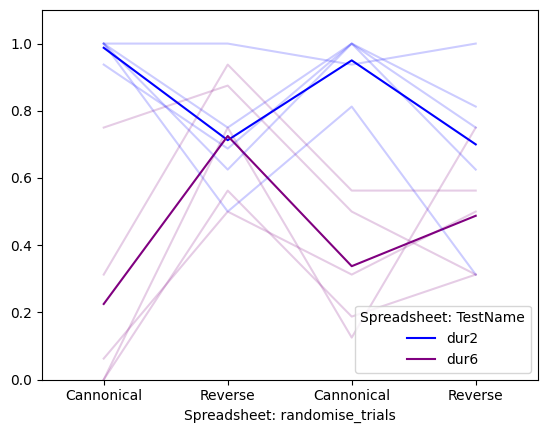

In [97]:
fig, ax = plt.subplots(1,1)
sum_stats_percept_wide.plot.line(ax = ax, color = ["blue","purple"])
ax.set_ylim(0,1.1)
ax.set_xticks([1,2, 3, 4],['Cannonical', 'Reverse', 'Cannonical', 'Reverse'])
ax.set_xlim([0.5, 4.5])

for p in sum_stats_stim_wide_byp_dur2.columns:
    ax.plot(sum_stats_percept_wide_byp_dur2[[p]], color = 'blue', alpha = 0.2)
    ax.plot(sum_stats_percept_wide_byp_dur6[[p]], color = 'purple', alpha = 0.2)

# Z Scored, Aggergate

## Production By Pecept

In [103]:
sum_stats_response = perceptual_data_critical[[condition_col, response_col, "z_length"]].groupby([condition_col, response_col]).mean()
sum_stats_response = sum_stats_response.reset_index()
sum_stats_response_wide = sum_stats_response.pivot(index = condition_col, columns = response_col, values = "z_length")

perceptual_data_critical_set = perceptual_data_critical.loc[perceptual_data_critical[response_col]=='set']
perceptual_data_critical_sat = perceptual_data_critical.loc[perceptual_data_critical[response_col]=='sat']

sum_stats_response_byp_set = perceptual_data_critical_set[[condition_col, participant_id_col, "z_length"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_response_byp_set = sum_stats_response_byp_set.reset_index()
sum_stats_response_wide_byp_set = sum_stats_response_byp_set.pivot(index = condition_col, columns = participant_id_col, values = "z_length")

sum_stats_response_byp_sat = perceptual_data_critical_sat[[condition_col, participant_id_col, "z_length"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_response_byp_sat = sum_stats_response_byp_sat.reset_index()
sum_stats_response_wide_byp_sat = sum_stats_response_byp_sat.pivot(index = condition_col, columns = participant_id_col, values = "z_length")

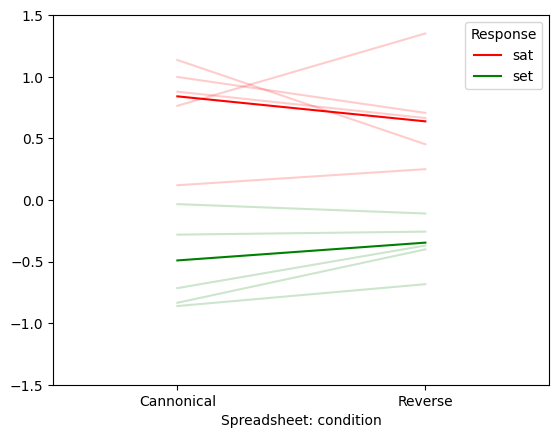

In [104]:
fig, ax = plt.subplots(1,1)
sum_stats_response_wide.plot.line(ax = ax, color = ['red', 'green'])
ax.set_ylim(-1.5,1.5)
ax.set_xticks([0,1],['Cannonical', 'Reverse'])
ax.set_xlim([-0.5, 1.5])
# ax.set_yticks([0,0.2,0.4,0.6,], [0,200,400,600,])

for p in sum_stats_response_wide_byp_sat.columns:
    ax.plot(sum_stats_response_wide_byp_sat[[p]], color = 'red', alpha = 0.2)
    ax.plot(sum_stats_response_wide_byp_set[[p]], color = 'green', alpha = 0.2)
    

In [108]:
sum_stats_response = perceptual_data_critical[[block_col, response_col, "z_length"]].groupby([block_col, response_col]).mean()
sum_stats_response = sum_stats_response.reset_index()
sum_stats_response_wide = sum_stats_response.pivot(index = block_col, columns = response_col, values = "z_length")

perceptual_data_critical_set = perceptual_data_critical.loc[perceptual_data_critical[response_col]=='set']
perceptual_data_critical_sat = perceptual_data_critical.loc[perceptual_data_critical[response_col]=='sat']

sum_stats_response_byp_set = perceptual_data_critical_set[[block_col, participant_id_col, "z_length"]].groupby([block_col, participant_id_col]).mean()
sum_stats_response_byp_set = sum_stats_response_byp_set.reset_index()
sum_stats_response_wide_byp_set = sum_stats_response_byp_set.pivot(index = block_col, columns = participant_id_col, values = "z_length")

sum_stats_response_byp_sat = perceptual_data_critical_sat[[block_col, participant_id_col, "z_length"]].groupby([block_col, participant_id_col]).mean()
sum_stats_response_byp_sat = sum_stats_response_byp_sat.reset_index()
sum_stats_response_wide_byp_sat = sum_stats_response_byp_sat.pivot(index = block_col, columns = participant_id_col, values = "z_length")

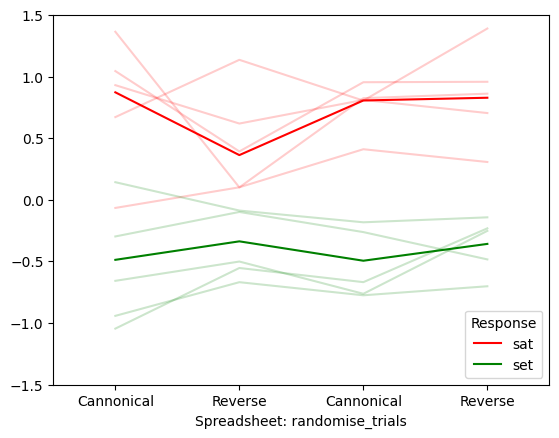

In [111]:
fig, ax = plt.subplots(1,1)
sum_stats_response_wide.plot.line(ax = ax, color = ['red', 'green'])
ax.set_ylim(-1.5,1.5)
ax.set_xticks([1,2, 3, 4],['Cannonical', 'Reverse', 'Cannonical', 'Reverse'])
ax.set_xlim([0.5, 4.5])
# ax.set_yticks([0,0.2,0.4,0.6,], [0,200,400,600,])

for p in sum_stats_response_wide_byp_sat.columns:
    ax.plot(sum_stats_response_wide_byp_sat[[p]], color = 'red', alpha = 0.2)
    ax.plot(sum_stats_response_wide_byp_set[[p]], color = 'green', alpha = 0.2)
    

## Production By Test Stimulus

In [46]:
sum_stats_stim = perceptual_data_critical[[condition_col, test_stim_col, "z_length"]].groupby([condition_col, test_stim_col]).mean()
sum_stats_stim = sum_stats_stim.reset_index()



sum_stats_stim = perceptual_data_critical[[condition_col, test_stim_col, "z_length"]].groupby([condition_col, test_stim_col]).mean()
sum_stats_stim = sum_stats_stim.reset_index()
sum_stats_stim_wide = sum_stats_stim.pivot(index = condition_col, columns = test_stim_col, values = "z_length")


perceptual_data_critical_dur2 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur2']
perceptual_data_critical_dur6 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur6']

sum_stats_stim_byp_dur2 = perceptual_data_critical_dur2[[condition_col, participant_id_col, "z_length"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_stim_byp_dur2 = sum_stats_stim_byp_dur2.reset_index()
sum_stats_stim_wide_byp_dur2 = sum_stats_stim_byp_dur2.pivot(index = condition_col, columns = participant_id_col, values = "z_length")

sum_stats_stim_byp_dur6 = perceptual_data_critical_dur6[[condition_col, participant_id_col, "z_length"]].groupby([condition_col, participant_id_col]).mean()
sum_stats_stim_byp_dur6 = sum_stats_stim_byp_dur6.reset_index()
sum_stats_stim_wide_byp_dur6 = sum_stats_stim_byp_dur6.pivot(index = condition_col, columns = participant_id_col, values = "z_length")

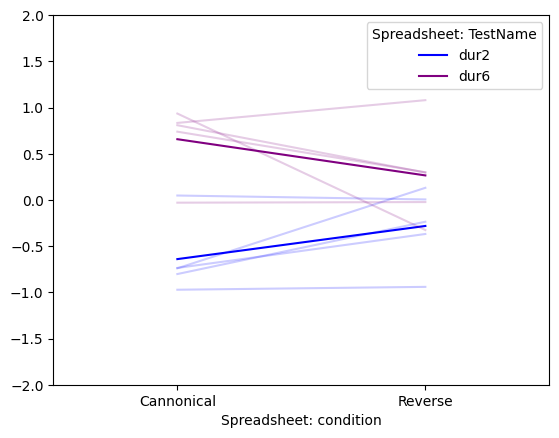

In [50]:
fig, ax = plt.subplots(1,1)
sum_stats_stim_wide.plot.line(ax = ax, color = ["blue","purple"])
ax.set_ylim(-2, 2)
ax.set_xticks([0,1],['Cannonical', 'Reverse'])
ax.set_xlim([-0.5, 1.5])
# ax.set_yticks([0,0.2,0.4,0.6,], [0,200,400,600,])

for p in sum_stats_stim_wide_byp_dur2.columns:
    ax.plot(sum_stats_stim_wide_byp_dur2[[p]], color = 'blue', alpha = 0.2)
    ax.plot(sum_stats_stim_wide_byp_dur6[[p]], color = 'purple', alpha = 0.2)
    

In [115]:
sum_stats_stim = perceptual_data_critical[[block_col, test_stim_col, "z_length"]].groupby([block_col, test_stim_col]).mean()
sum_stats_stim = sum_stats_stim.reset_index()



sum_stats_stim = perceptual_data_critical[[block_col, test_stim_col, "z_length"]].groupby([block_col, test_stim_col]).mean()
sum_stats_stim = sum_stats_stim.reset_index()
sum_stats_stim_wide = sum_stats_stim.pivot(index = block_col, columns = test_stim_col, values = "z_length")


perceptual_data_critical_dur2 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur2']
perceptual_data_critical_dur6 = perceptual_data_critical.loc[perceptual_data_critical[test_stim_col]=='dur6']

sum_stats_stim_byp_dur2 = perceptual_data_critical_dur2[[block_col, participant_id_col, "z_length"]].groupby([block_col, participant_id_col]).mean()
sum_stats_stim_byp_dur2 = sum_stats_stim_byp_dur2.reset_index()
sum_stats_stim_wide_byp_dur2 = sum_stats_stim_byp_dur2.pivot(index = block_col, columns = participant_id_col, values = "z_length")

sum_stats_stim_byp_dur6 = perceptual_data_critical_dur6[[block_col, participant_id_col, "z_length"]].groupby([block_col, participant_id_col]).mean()
sum_stats_stim_byp_dur6 = sum_stats_stim_byp_dur6.reset_index()
sum_stats_stim_wide_byp_dur6 = sum_stats_stim_byp_dur6.pivot(index = block_col, columns = participant_id_col, values = "z_length")

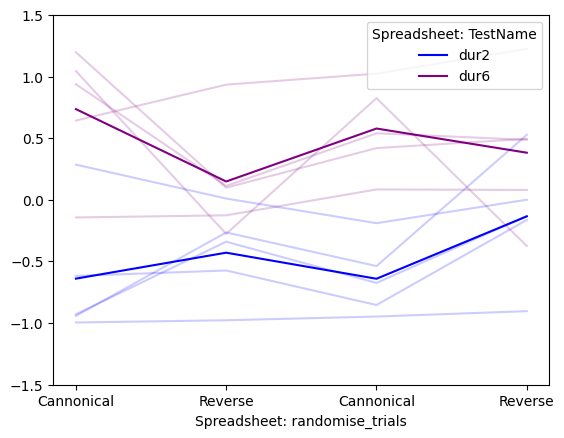

In [117]:
fig, ax = plt.subplots(1,1)
sum_stats_stim_wide.plot.line(ax = ax, color = ["blue","purple"])
ax.set_ylim(-2, 2)
ax.set_ylim(-1.5,1.5)
ax.set_xticks([1,2, 3, 4],['Cannonical', 'Reverse', 'Cannonical', 'Reverse'])
# ax.set_yticks([0,0.2,0.4,0.6,], [0,200,400,600,])


for p in sum_stats_stim_wide_byp_dur2.columns:
    ax.plot(sum_stats_stim_wide_byp_dur2[[p]], color = 'blue', alpha = 0.2)
    ax.plot(sum_stats_stim_wide_byp_dur6[[p]], color = 'purple', alpha = 0.2)
    